<a href="https://colab.research.google.com/github/nhuang37/aut_GNN/blob/main/project_subgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
from torch.nn import Parameter, ParameterList
import matplotlib.pyplot as plt
import seaborn as sns

### Simulation: $f: R^3 \to R$, $G = S_3$, subgroups $S_2$ and trivial group. 

In [3]:
#src: adapated from https://github.com/nhuang37/dimensionality_reduction/blob/main/Projections.ipynb

def make_beta(p, group):
    '''
    Return the true coefficient with a constant norm 1
    p: number of covariates (features)
    group: "S3" (return all ones beta); "S2" ([1,1,c]); "I" random sample from normal, "S2-3": all ones with the last cor + epsilon
    '''
    np.random.seed(0)
    if group == "I": #(isotropic case)
      beta = np.random.normal(size=p)
    elif group == "S2":
      beta = np.hstack((np.ones(2), np.random.normal(size=1)))
    elif group == "S3":
      beta = np.ones(3)
    else: 
      beta = np.ones(3)
      beta[2] = beta[2] * 0.92
    
    return beta / np.linalg.norm(beta)

def make_data(beta, n, sigma, seed=0, pytorch=False):
    '''
    Return the training data tuple (Y, X): Y \in \R^n, X \in \R^{n x p}
    beta: true param
    n: number of training examples
    sigma: noise standard deviation
    '''
    np.random.seed(seed)
    p = beta.shape[0]
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=np.eye(p), size=n)
    noise = np.random.normal(loc=0, scale=sigma, size=n)
    Y = X @ beta + noise
    if pytorch:
      return torch.FloatTensor(Y), torch.FloatTensor(X)
    else:
      return Y, X

In [4]:
def train_test_data_torch(Ntrial, n, n_test, p, beta, SNR):
  np.random.seed(8675309 + 1)
  # compute noise std
  sigma = float(np.linalg.norm(beta)/SNR)
  print(sigma)
  # make maximal train and test sets
  X_MC = torch.zeros((Ntrial, n, p))
  Y_MC = torch.zeros((Ntrial, n))
  for trial in range(Ntrial):
    Y_MC[trial], X_MC[trial] = make_data(beta, n, sigma, seed=trial, pytorch=True)

  X_tests = torch.zeros((Ntrial, n_test, p))
  Y_tests = torch.zeros((Ntrial, n_test))
  for trial in range(Ntrial):
    Y_tests[trial], X_tests[trial] = make_data(beta, n_test, sigma, seed=n_test + trial, pytorch=True)
  
  return Y_MC, X_MC, Y_tests, X_tests, beta, SNR, sigma


def train_test_data(Ntrial, n, n_test, p, beta, SNR):
  np.random.seed(8675309 + 1)
  # compute noise std
  sigma = np.linalg.norm(beta)/SNR
  print(sigma)
  # make maximal train and test sets
  X_MC = np.zeros((Ntrial, n, p))
  Y_MC = np.zeros((Ntrial, n))
  for trial in range(Ntrial):
    Y_MC[trial], X_MC[trial] = make_data(beta, n, sigma, seed=trial)

  X_tests = np.zeros((Ntrial, n_test, p))
  Y_tests = np.zeros((Ntrial, n_test))
  for trial in range(Ntrial):
    Y_tests[trial], X_tests[trial] = make_data(beta, n_test, sigma, seed=n_test + trial)
  
  return Y_MC, X_MC, Y_tests, X_tests, beta, SNR, sigma


In [5]:

# evaluating data points with Mean Square Error
def criterion(y_pred, y):
    return torch.mean((y_pred - y) ** 2)
 
def get_lstsq(X, y, group, num_epochs=20, lr=0.1, verbose=False):
  '''
  X: data features (n by p)
  y: data labels (n by 1)
  '''
  if group == 'I': #vanilla lstsq
    w = Parameter(torch.Tensor(p*p)) #torch.empty(p, requires_grad=True) #torch.tensor(-10.0, requires_grad=True)
    torch.nn.init.uniform_(w)
    optimizer = torch.optim.SGD([w], lr=lr)


  elif group == 'S2':
    w1 = Parameter(torch.Tensor(1))
    torch.nn.init.uniform_(w1)
    w2 = Parameter(torch.Tensor(1))
    torch.nn.init.uniform_(w2)
    optimizer = torch.optim.SGD([w1, w2], lr=lr)


  else: #S3
    w1 = Parameter(torch.Tensor(1))
    torch.nn.init.uniform_(w1)
    optimizer = torch.optim.SGD([w1], lr=lr)

 
  for i in range(num_epochs):
      # making predictions with forward pass
      if group == 'S2':
        w = torch.cat([w1.expand(2),w2])
      elif group == "S3":
        w = w1.expand(p)
      else:
        pass
      optimizer.zero_grad()
      Y_pred = X @ w
      # calculating the loss between original and predicted data points
      loss = criterion(Y_pred, y)
      # backward pass for computing the gradients of the loss w.r.t to learnable parameters
      loss.backward()
      optimizer.step()
      # priting the values for understanding
      if verbose:
        print(f'epoch={i}, loss={loss.item():.2f}')
  return w

#### Experiment Set-up

Graph regression: We observe n samples $(x_i, y_i)$ where $x_i \in R^3$ are node features, and $y_i = x_i  \beta + \epsilon \in R$ are the graph level output. We investigate how the generalization error (i.e., mean squared loss on the test samples) changes when the target function $\beta$ has different symmetries. We consider the following $4$ kinds of $\beta$ and its corresponding least-squares estimator:
- trivial group $I$-invariant
- $S_2$-invariant 
- $S_2$-invariant but close to $S_3$ invariant
- $S_3$ invariant


In [6]:
def run_exp(Ntrial, n_max, n_test, p, beta, SNR, ns, groups):
  DS = train_test_data_torch(Ntrial, n_max, n_test, p, beta, SNR)
  Y_MC, X_MC, Y_tests, X_tests, beta, SNR, sigma = DS
  results = {'I': np.zeros((Ntrial, len(ns))), 'S2': np.zeros((Ntrial, len(ns))), 'S3': np.zeros((Ntrial, len(ns)))}
  for t in range(Ntrial):
    for id, n in enumerate(ns):
      for group in groups:
        w_est = get_lstsq(X_MC[t][:n, :], Y_MC[t][:n], group, num_epochs=50)
        Y_test_pred = X_tests[t] @ w_est
        error = criterion(Y_test_pred, Y_tests[t])
        results[group][t,id] = error.item()
  return results

In [7]:
Ntrial = 10
n_max = 50
n_test = 200
p = 3
SNR = 6
ns = np.arange(10, 40, 2) 
groups = ['I', 'S2', 'S3']


beta_3 = make_beta(p, group="S3")
results_S3 = run_exp(Ntrial, n_max, n_test, p, beta_3, SNR, ns, groups)

beta_23 =  make_beta(p, group="S2-3")
results_S23 = run_exp(Ntrial, n_max, n_test, p, beta_23, SNR, ns, groups)

beta_2 = make_beta(p, group="S2")
results_S2 = run_exp(Ntrial, n_max, n_test, p, beta_2, SNR, ns, groups)

beta_free = make_beta(p, group="I")
results_I = run_exp(Ntrial, n_max, n_test, p, beta_free, SNR, ns, groups)


0.16666666666666666
0.16666666666666663
0.16666666666666666
0.16666666666666666


In [8]:
def get_threshold(beta, SNR):
  '''
  Compute the theoretically predicted threshold where S_3 is better than S_2 before such threshold
    S3_gain: -2/3 * 1 * (beta[0] - beta[-1])**2 + (sigma**2)*2/n-4
    S2_gain: (sigma**2)/n-4
    solve for n yields:  (sigma**2)/n-4 > 2/3 * 1 * (beta[0] - beta[-1])**2
  '''
  sigma = float(np.linalg.norm(beta)/SNR)
  denom = 2/3 * 1 * (beta[0] - beta[-1])**2
  return 4 + (sigma**2)/denom



In [9]:
n_threshold = get_threshold(beta_23, SNR)
n_threshold

22.531250000000007

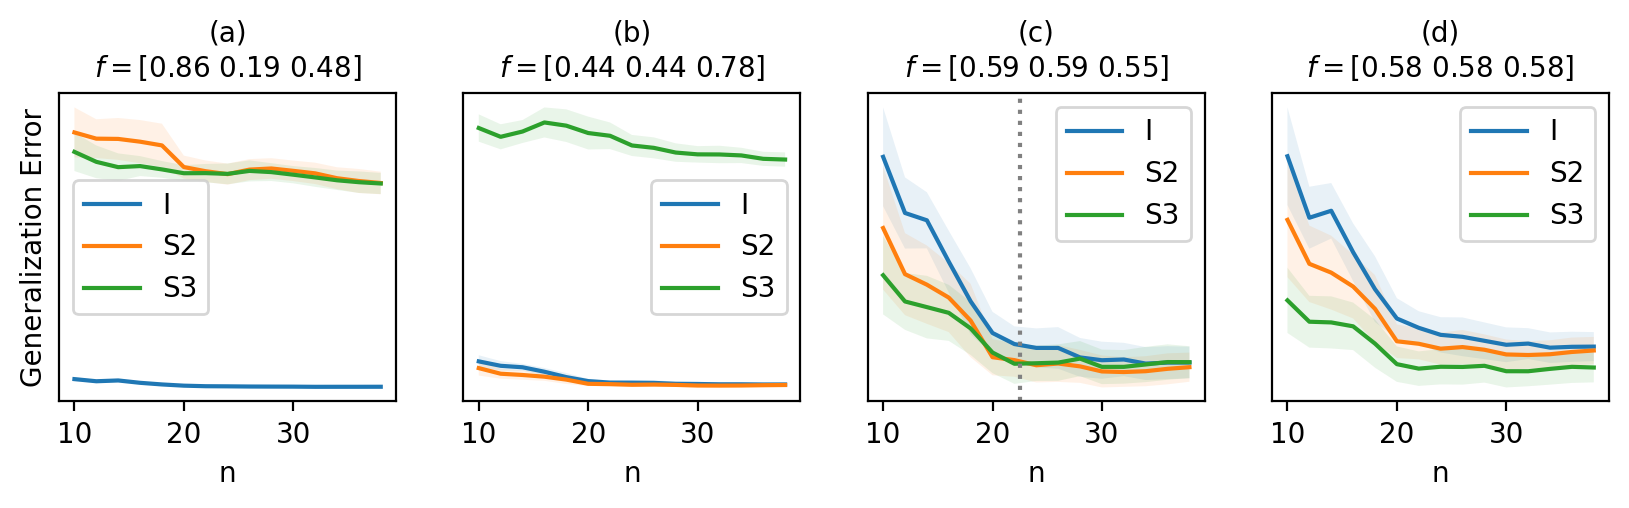

In [10]:
fig, axs = plt.subplots(ncols=4, figsize=(10,2), dpi=200)
beta_all = [beta_free, beta_2, beta_23, beta_3]
title_ids = ["(a)", "(b)", "(c)", "(d)"]
for i, results in enumerate([results_I, results_S2, results_S23, results_S3]):
  for group in groups:
    mean = results[group].mean(axis=0)
    stderr = results[group].std(axis=0)/np.sqrt(10)
    axs[i].plot(ns, mean , label=group, linewidth=1.5)
    axs[i].fill_between(ns, mean+stderr, mean-stderr, alpha=0.1)
  #ax.legend(fontsize=15)
  axs[i].set_yticks([])
  axs[i].set_xlabel("n")
  #axs[i].set_yscale("log")
  axs[i].set_title(f'{title_ids[i]}\n' + r"$f=$" + f"{np.array2string(beta_all[i], precision=2, floatmode='fixed')}", fontsize=10)
  axs[i].legend(loc="best", fontsize=10)
  
axs[2].axvline(x=n_threshold, linestyle=":", color="gray")
axs[0].set_ylabel("Generalization Error", rotation=90)

plt.show()

In [11]:
Ntrial = 10
n_max = 50
n_test = 200
p = 3
SNR = 6
ns = np.arange(10, 40, 2) 
groups = ['I', 'S2', 'S3']


beta_3 = make_beta(p, group="S3")

In [12]:
beta_3

array([0.57735027, 0.57735027, 0.57735027])